In [ ]:
!pip install huggingface_hub
!huggingface-cli login
!pip install git+https://github.com/openai/CLIP.git
!pip install accelerate
!pip install pynvml
!pip install transformers


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
^C
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-q3n2k6q7
  Running command git clone

In [ ]:
import torch
import transformers
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria, StoppingCriteriaList
from tqdm import tqdm
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
from transformers import GPTNeoXForCausalLM, AutoTokenizer

class CocoDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer =  AutoTokenizer.from_pretrained("StabilityAI/stablelm-tuned-alpha-3b")
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image_id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        self.captions_tokens = []
        self.caption2embedding = []
        max_seq_len = 0
        for caption in captions_raw:
            self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
            self.caption2embedding.append(caption["clip_embedding"])
            max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
        with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
            pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))


class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ImageCaptioningModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.gpt_neox.embed_in(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def train(self):
      self.gpt.eval()

    def parameters(self):
      return self.clip_project.parameters()

    def __init__(self, prefix_length: int, prefix_size: int = 512,
                 num_layers: int = 8):
        super(ImageCaptioningModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPTNeoXForCausalLM.from_pretrained("StabilityAI/stablelm-tuned-alpha-3b")
        print(self.gpt)
        self.gpt_embedding_size = self.gpt.gpt_neox.embed_in.weight.shape[1]
        self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))


In [ ]:
device = torch.device('cuda')

In [ ]:
prefix_length = 10
dataset = CocoDataset('/content/drive/MyDrive/Trained Model Check Points/oscar_split_ViT-B_32_train.pkl', prefix_length, normalize_prefix = False)

prefix_dim = 512
model = ImageCaptioningModel(prefix_length, prefix_size = prefix_dim, num_layers = 8)

Data size is 566747


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50688, 4096)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [ ]:
batch_size = 16
epochs = 5
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5, eps=1e-4)
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, drop_last = True)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 5000, num_training_steps = epochs * len(train_dataloader))

In [ ]:
# model.eval()

model.train()

This is the loop used to train our image captioning model. Note that we initially used the Summary Writer class from tensor board in order to track the loss. We also used utility functions to track gpu utilization and space.




In [ ]:
# writer = SummaryWriter()

starting_epoch = 0
model = model.to(device)

for epoch in range(epochs):
  print(f">>> Training epoch {epoch}")
  sys.stdout.flush()
  progress = tqdm(total=len(train_dataloader),desc='llama fine-tuning')
  total_loss = 0
  for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
    if idx%20==0:
      print(idx)
    model.zero_grad()
    tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
    # print_gpu_utilization()
    outputs = model(tokens, prefix, mask)
    logits = outputs.logits[:, dataset.prefix_length - 1: -1]
    loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index= 0)
    total_loss += loss.item()
    # print_gpu_utilization()
    if(idx%200==0):
      print(f'Average loss so far at batch number {idx+1} is {total_loss/(idx+1)}')
      # writer.add_scalar('Loss/train', loss, epoch * len(train_dataloader) + idx)
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  print(f'Average loss for epoch is {total_loss/len(train_dataloader)}')
  torch.save({
          'epoch': {starting_epoch + epoch},
          'loss': {total_loss/len(train_dataloader)},
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
      }, f'/content/drive/My Drive/Trained Model Check Points/StableLm_prefix15/model_checkpoint_{starting_epoch + epoch}.pt') # save the model, losses
  print(f'model saved for epoch {epoch}')

# writer.close()

During training, we saved model checkpoints. We can load the learned weights for different model ecpochs here in order to run inference.

In [ ]:
model = model.half()

# Define the path to the saved checkpoint
checkpoint_path = '/content/drive/MyDrive/Trained Model Check Points/Stablelm/model_checkpoint_7.pt'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Update model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f'Model loaded from epoch {epoch} with loss {loss}')

model = model.to(device)

Model loaded from epoch {7} with loss {1.867681791713721}


Now, we evaluate our image captioning model on the validation dataset. The metric used was BLEU@1 score.

In [ ]:
import pickle

with open('/content/drive/MyDrive/Trained Model Check Points/test set/oscar_split_500_ViT-B_32_train.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# Create a dictionary with the image path as the key and array of ground truth captions as the value
ground_truth_captions = {}

for item in test_data['captions']:
  prepend_zeros = 6 - len(item['image_id'])
  item['image_id'] = '0' * prepend_zeros + item['image_id']
  image_file_path = f"/content/drive/MyDrive/Trained Model Check Points/test set/test_set/COCO_train2014_000000{item['image_id']}.jpg"

  if image_file_path not in ground_truth_captions:
      ground_truth_captions[image_file_path] = []

  ground_truth_captions[image_file_path].append(item['caption'])

In [ ]:
def generate_caption_with_beam_search(model, image_path, tokenizer, max_length=67, num_beams=5, temperature=1.):
    image = io.imread(image_path)
    pil_image = PIL.Image.fromarray(image)

    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device)
        prefix = prefix / prefix.norm(2, -1).item()
        prefix_embed = model.clip_project(prefix).reshape(1, 10, -1)
    gpt_model = model.gpt
    generated_ids = gpt_model.generate(inputs_embeds=prefix_embed, max_length=67,
                                       num_beams=5, temperature=1.,
                                       pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)

    # Decode to get the caption
    generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    index_period = generated_caption.find('.')
    generated_caption = generated_caption[:index_period+1]

    return generated_caption

Try a different Bleu score

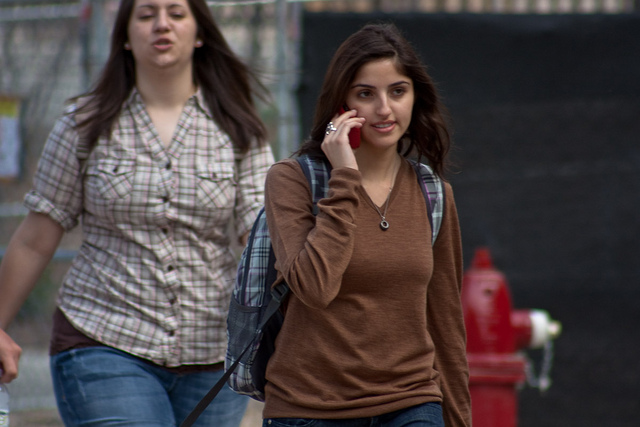

A woman is talking on a cell phone.


In [ ]:
import skimage.io as io
import PIL.Image
import clip
import numpy as np

clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

tokenizer =  AutoTokenizer.from_pretrained("StabilityAI/stablelm-tuned-alpha-3b")

use_beam_search = True

image = io.imread('/content/drive/My Drive/Trained Model Check Points/Stablelm_200/test_images/COCO_train2014_000000047093.jpg')
pil_image = PIL.Image.fromarray(image)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device)
    prefix = prefix / prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, 10, -1)
if use_beam_search:
    generated_text_prefix = generate_caption_with_beam_search(model, '/content/drive/My Drive/Trained Model Check Points/Stablelm_200/test_images/COCO_train2014_000000047093.jpg', tokenizer)
    print(generated_text_prefix)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_score(model_caption, true_captions):
    # Convert the model-generated caption to a list of words
    model_caption_tokens = model_caption.split()

    # Convert the true_captions to a list of lists of words
    true_captions_tokens = [caption.split() for caption in true_captions]

    smooth = SmoothingFunction().method1

    # Calculate BLEU score with weights (1-gram)
    bleu_score = sentence_bleu(true_captions_tokens, model_caption_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth)

    return bleu_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score_eval(model, tokenizer, captions):
    total_bleu = 0

    for idx, (image_path, true_captions) in enumerate(captions.items()):
      model_caption = generate_caption_with_beam_search(model, image_path, tokenizer)
      bleu_score = calculate_bleu_score(model_caption, true_captions)
      total_bleu += bleu_score

    return total_bleu/len(ground_truth_captions)


MLP_StableLM_bleu_score = bleu_score_eval(model, tokenizer, ground_truth_captions)
print(MLP_StableLM_bleu_score)

0.5493907947831784


Utility function for tracking gpu utilization

In [ ]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")